# <center>PlotBathymetryPNASBogumil_etal_2024 JN</center>
This jupyter-notebook is used to plot 1) bathymetry calculated from Bogumil et al. (2024) https://doi.org/10.1073/pnas.2400232121, 2) basin boundaries used in the study.

<center>Figure 1: ....</center>
<br>
<br>





## Import libraries

In [1]:
# For reading matlab files that store plate boundaries.
import scipy.io
import os

# For plotting
from netCDF4 import Dataset
import copy as cp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Polygon
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature

## Read in matlab plate boundaries used in Bogumil et al. (2024)

In [7]:
def load_netcdf_data(age):
    # Read bathymetry file.
    ds = Dataset(os.getcwd()+'/PNAS_Bogumil_Results/bathymetryNCFiles/Bathymetry_{}Ma.nc'.format(age))

    # Assign data to variables
    lon, lat = np.meshgrid(ds['lon'][:], ds['lat'][:]);
    z = ds['z'][:].data;
    continents = ds['z'][:].mask;
    continentsnew = cp.deepcopy(continents).astype(float)
    continentsnew[continentsnew==0] = np.nan

    
    # Close dataset
    ds.close();
    
    # Return variables
    return lon, lat, z, continentsnew


def remove_non_unique_rows(arr):
    # Count occurrences of each row
    unique_rows, counts = np.unique(arr, axis=0, return_counts=True)
    # Only keep rows that appear once
    unique_only = unique_rows[counts == 1]
    return unique_only

def readBoundaries(age, pacificValues=[1,0]):
    # Load the .mat file
    mat_data = scipy.io.loadmat(os.getcwd()+'/PNAS_Bogumil_Results/basinPolygons/Earth{}Ma_basin_poly.mat'.format(age))

    # Print variable names in the file (ignoring MATLAB metadata entries)
    variable_names = [key for key in mat_data.keys() if not key.startswith('__')]
    #print("Variables in .mat file:", variable_names);

    # Access a specific variable (replace 'your_variable_name' as needed)
    boundaries = mat_data['Earth{}Ma'.format(age)][0][0];
    
    # Merge two Pacific boundaries
    if pacificValues is not None:
        x = np.vstack( (boundaries[pacificValues[0]], boundaries[pacificValues[1]]) )
        x = remove_non_unique_rows(x)
        boundariesOut = np.array(np.arange(len(boundaries)-1), dtype=object)
        boundariesOut[0] = x

        cnt = 0;
        for i in range(len(boundaries)):
            #print(i, (pacificValues[0]==i), (pacificValues[1]==i), ((pacificValues[0]==i) | (pacificValues[1]==i)))
            if not ((pacificValues[0]==i) | (pacificValues[1]==i)):
                #print(i)
                boundariesOut[cnt+1] = boundaries[i]
                boundariesOut[cnt+1] = boundaries[i]
                cnt+=1;
    else:
        boundariesOut = np.array(np.arange(len(boundaries)), dtype=object)
        for i in range(len(boundaries)):
            boundariesOut[i] = boundaries[i]
        

    return boundariesOut

def haversine_distance(lat1, lon1, lat2, lon2, radius):
    """
    haversine_distance function calculate the great-circle distance
    between two points on a sphere using the Haversine formula.
    
    Parameters
    ----------
    lat1 : FLOAT
        Coordinate of first point latitude, in degree.
    lon1 : FLOAT
        Coordinate of first point longitude, in degree.
    lat2 : FLOAT or NUMPY VECTOR
        Coordinate of second point latitude, in degree.
    lon2 : FLOAT or NUMPY VECTOR
        Coordinate of second point longitude, in degree.
    radius : FLOAT
        Radius of the sphere.
    
    Returns
    --------
    distance : FLAOT
        Distance between the two points in the same unitas the radius.
    """
    # Convert latitude and longitude from degrees to radians
    lat1, lon1 = np.radians(lat1), np.radians(lon1)
    lat2, lon2 = np.radians(lat2), np.radians(lon2)
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2

    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    # Distance
    distance = radius * c
    return distance

In [4]:
def reorderBoundary(boundariesIn):

    # Order coastline points
    boundaries = {"original":cp.deepcopy(boundariesIn),
                  "ordered":cp.deepcopy(boundariesIn)}

    for i in range(len(boundaries["original"])-1):
        # Set coordinates to closest landmass dictionary entry
        boundaries['M{:0.0f}_lon'.format(i)] = boundaries1[0][:,0];
        boundaries['M{:0.0f}_lat'.format(i)] = boundaries1[0][:,1];

    # 4. Order coastline points
    for i in range(len(boundaries["original"])-1):
        print(i)
        # Iterate over landmasses

        # Select one coastline point as reference
        refPoint = [boundaries['M{:0.0f}_lat'.format(i)][0],
                    boundaries['M{:0.0f}_lon'.format(i)][0]]
        # Assign all other coastline points to vectors
        latB = boundaries['M{:0.0f}_lat'.format(i)][1:];
        lonB = boundaries['M{:0.0f}_lon'.format(i)][1:];
        # Make new vectors to hold ordered coastlines points
        latBO = np.array([]);
        lonBO = np.array([]);

        # Make vector of ordered coastline points 
        for j in range(len(latB)):
            # Iterate over amount of other coastline points

            # Find the closest coastline point and set as new reference
            if len(latB)>1:
                # Find the closest coastline point and set as new reference
                try:
                    distance = haversine_distance(lat1=refPoint[0],
                                                        lon1=refPoint[1],
                                                        lat2=latB,
                                                        lon2=lonB,
                                                        radius=6371);

                    refPoint = [latB[distance==np.min(distance)][0],
                                lonB[distance==np.min(distance)][0]];
                    # Remove found closest point from latLM and lonLM vector
                    latB = latB[distance!=np.min(distance)];
                    lonB = lonB[distance!=np.min(distance)];
                except:
                    distance = haversine_distance(lat1=refPoint[0],
                                    lon1=refPoint[1],
                                    lat2=latB,
                                    lon2=lonB,
                                    radius=6371);

                    refPoint = [latB[distance==np.min(distance)][0],
                                lonB[distance==np.min(distance)][0]];
                    # Remove found closest point from latLM and lonLM vector
                    latLM = latB[distance!=np.min(distance)];
                    lonLM = lonB[distance!=np.min(distance)];
            else:
                # Set last point as reference
                refPoint = [latB, lonB];

            # Append point to new vectors
            latBO = np.append(latBO, refPoint[0]);
            lonBO = np.append(lonBO, refPoint[1]);

        # Reassign coastline locations to new ordered coastline locations
        boundaries['M{:0.0f}_lat'.format(i)] = latBO;
        boundaries['M{:0.0f}_lon'.format(i)] = lonBO;

        # Order
        boundaries["ordered"][i] = np.vstack( (lonBO, latBO) ).T
    
    return boundaries['ordered']



## Plot 

/tmp/ipykernel_14160/1733492937.py:90: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -180 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  lonB[lonB < -180] = -180;


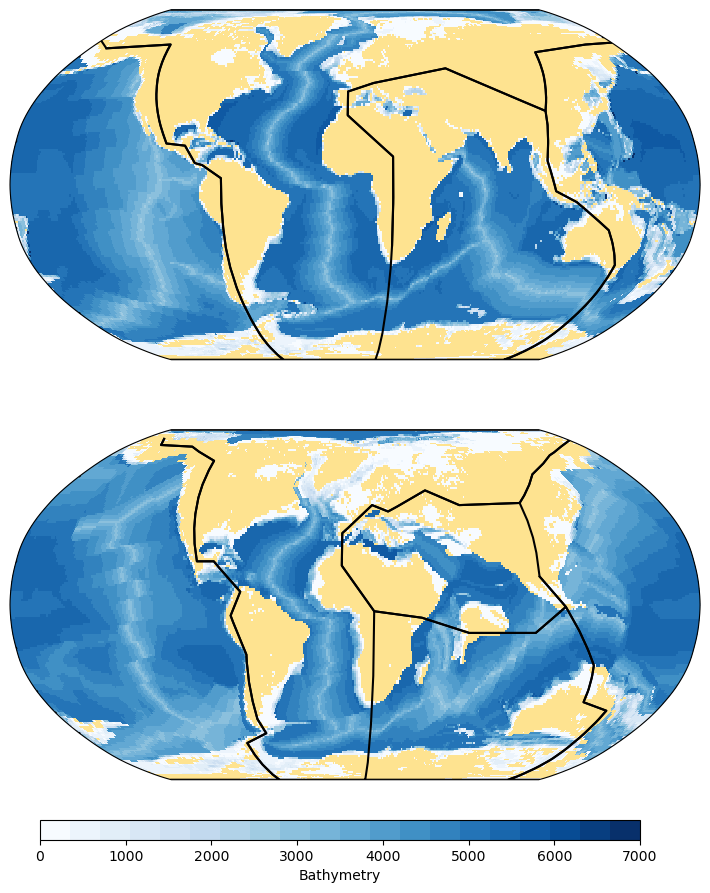

In [31]:
# Load NetCDF file
age1 = 0; age2 = 60;

lon, lat, z1, continents1 = load_netcdf_data(age1)
lon, lat, z2, continents2 = load_netcdf_data(age2)

# Load basin boundaries
boundaries1 = readBoundaries(age1, None)
#boundaries1 = reorderBoundary(boundaries1)
boundaries2 = readBoundaries(age2, None)
#boundaries2 = reorderBoundary(boundaries2)

# Reduce resolution
factor = 10
lon = lon[::factor].T[::factor].T
lat = lat[::factor].T[::factor].T
z1  = z1[::factor].T[::factor].T
z2  = z2[::factor].T[::factor].T
continents1 = continents1[::factor].T[::factor].T
continents2 = continents2[::factor].T[::factor].T


# Create the figure
## Set up projection and figure
proj = ccrs.Robinson()
fig, axs = plt.subplots(
    2, 1,
    figsize=(12, 10),
    subplot_kw={'projection': proj},
    constrained_layout=False
)

# Define common color scale
vmin = np.nanmin([np.nanmin(z1), np.nanmin(z2)])
vmax = np.nanmax([np.nanmax(z1), np.nanmax(z2)])
vmin = 0
vmax = 7000


# Example polygon (replace with your actual lat/lon)
poly_lats = [-10, -10, 0, 0, -10]
poly_lons = [100, 110, 110, 100, 100]
polygon = Polygon(zip(poly_lons, poly_lats))

# Sample reversed blue cmap for bathymetry
N = 20
blues_cm = mpl.colormaps['Blues'].resampled(N)

# Plot first dataset
## Plot bathymetry
mesh11 = axs[0].pcolormesh(lon, lat, z1, transform=ccrs.PlateCarree(), cmap=blues_cm, shading='auto', vmin=vmin, vmax=vmax)
## Plot Land
mesh12 = axs[0].pcolormesh(lon, lat, continents1, transform=ccrs.PlateCarree(), cmap='YlOrBr', shading='auto', vmin=0, vmax=4)
## Plot basin boundaries
colors = ['black', 'black', 'black', 'black', 'black']

#colors = ['black', 'black', 'red', 'green']
cnt=0
for boundary in boundaries1:
    lonB = boundary[:,0]
    latB = -1*boundary[:,1]
    latB[latB > 90] = 90;
    latB[latB < -90] = -90;
    lonB[lonB > 180] = 180;
    lonB[lonB < -180] = -180;

    polygon1 = Polygon(zip(lonB, latB))
    colori = colors[cnt]
    axs[0].plot(lonB, latB, linestyle='solid', color=colori, transform=ccrs.PlateCarree())
    #axs[0].add_geometries([polygon1], crs=ccrs.PlateCarree(), facecolor='none', edgecolor=colori, linewidth=2)
    cnt+=1;


# Plot second dataset
## Plot bathymetry
mesh21 = axs[1].pcolormesh(lon, lat, z2, transform=ccrs.PlateCarree(), cmap=blues_cm, shading='auto', vmin=vmin, vmax=vmax)
## Plot Land
mesh22 = axs[1].pcolormesh(lon, lat, continents2, transform=ccrs.PlateCarree(), cmap='YlOrBr', shading='auto', vmin=0, vmax=4)
## Plot basin boundaries
## Plot basin boundaries
#colors = ['black', 'black', 'blue', 'red', 'white']
cnt=0
for boundary in boundaries2:
    lonB = boundary[:,0]
    latB = -1*boundary[:,1]
    
    latB[latB > 90] = 90;
    latB[latB < -90] = -90;
    lonB[lonB > 180] = 180;
    lonB[lonB < -180] = -180;

    polygon1 = Polygon(zip(lonB, latB))
    colori = colors[cnt]
    axs[1].plot(lonB, latB, linestyle='solid', color=colori, transform=ccrs.PlateCarree())
    #axs[1].add_geometries([polygon1], crs=ccrs.PlateCarree(), facecolor='none', edgecolor=colori, linewidth=2)
    cnt+=1;


# Add shared colorbar
cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(mesh21, cax=cbar_ax, orientation='horizontal')
cbar.set_label("Bathymetry")


# Save figure
plt.savefig("PNAS_Bogumil_Results/ExoCycle_ModelPaper_Figure1.png", dpi=600, transparent=True)
plt.savefig("PNAS_Bogumil_Results/ExoCycle_ModelPaper_Figure1.svg", transparent=True)
